# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [2]:
import pandas as pd
from palmerpenguins import load_penguins
penguins = load_penguins()
penguins_new = pd.get_dummies(penguins, columns= ["species", "island", "sex"], drop_first = True)
penguins_new.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_male
0,39.1,18.7,181.0,3750.0,2007,False,False,False,True,True
1,39.5,17.4,186.0,3800.0,2007,False,False,False,True,False
2,40.3,18.0,195.0,3250.0,2007,False,False,False,True,False
3,NaN,NaN,NaN,NaN,2007,False,False,False,True,False
4,36.7,19.3,193.0,3450.0,2007,False,False,False,True,False


Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.


Confusion Matrix (kNN (k=5)):
[[45  0  0]
 [ 1 20  0]
 [ 0  0 37]]

Classification Report (kNN (k=5)):
              precision    recall  f1-score   support

      Adelie       0.98      1.00      0.99        45
   Chinstrap       1.00      0.95      0.98        21
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.99       103
   macro avg       0.99      0.98      0.99       103
weighted avg       0.99      0.99      0.99       103

Accuracy (kNN (k=5)): 0.99, Precision: 0.99, Recall: 0.99, F1-Score: 0.99

Confusion Matrix (kNN (k=8)):
[[45  0  0]
 [ 0 21  0]
 [ 0  0 37]]

Classification Report (kNN (k=8)):
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        45
   Chinstrap       1.00      1.00      1.00        21
      Gentoo       1.00      1.00      1.00        37

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted av

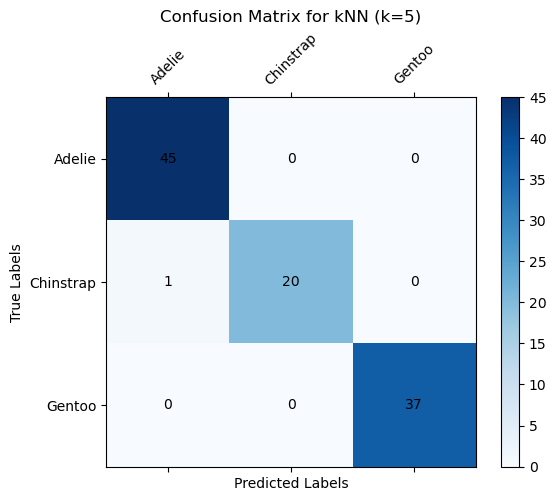

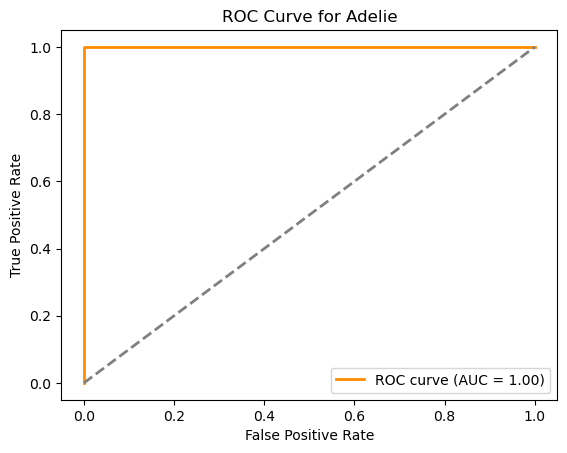

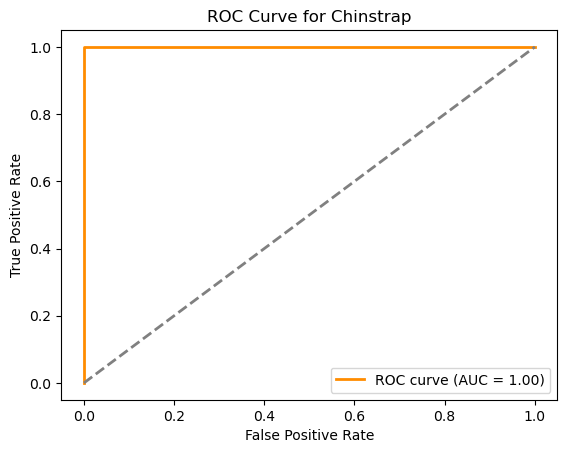

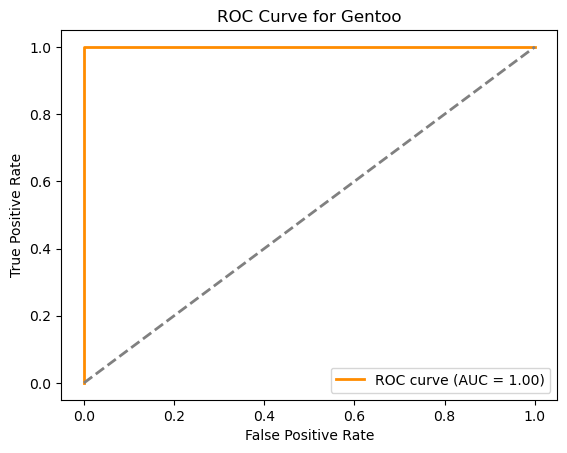

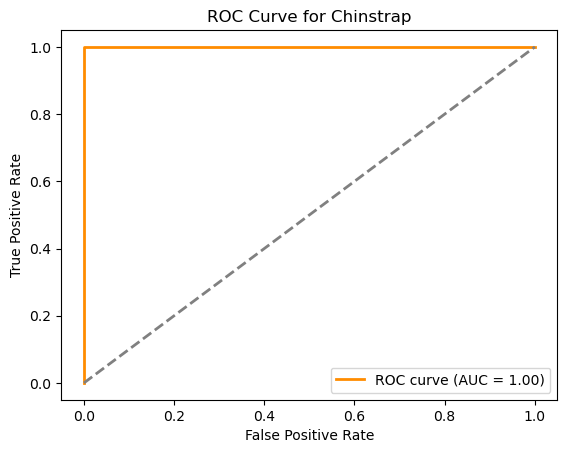

<positron-console-cell-14>:119: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


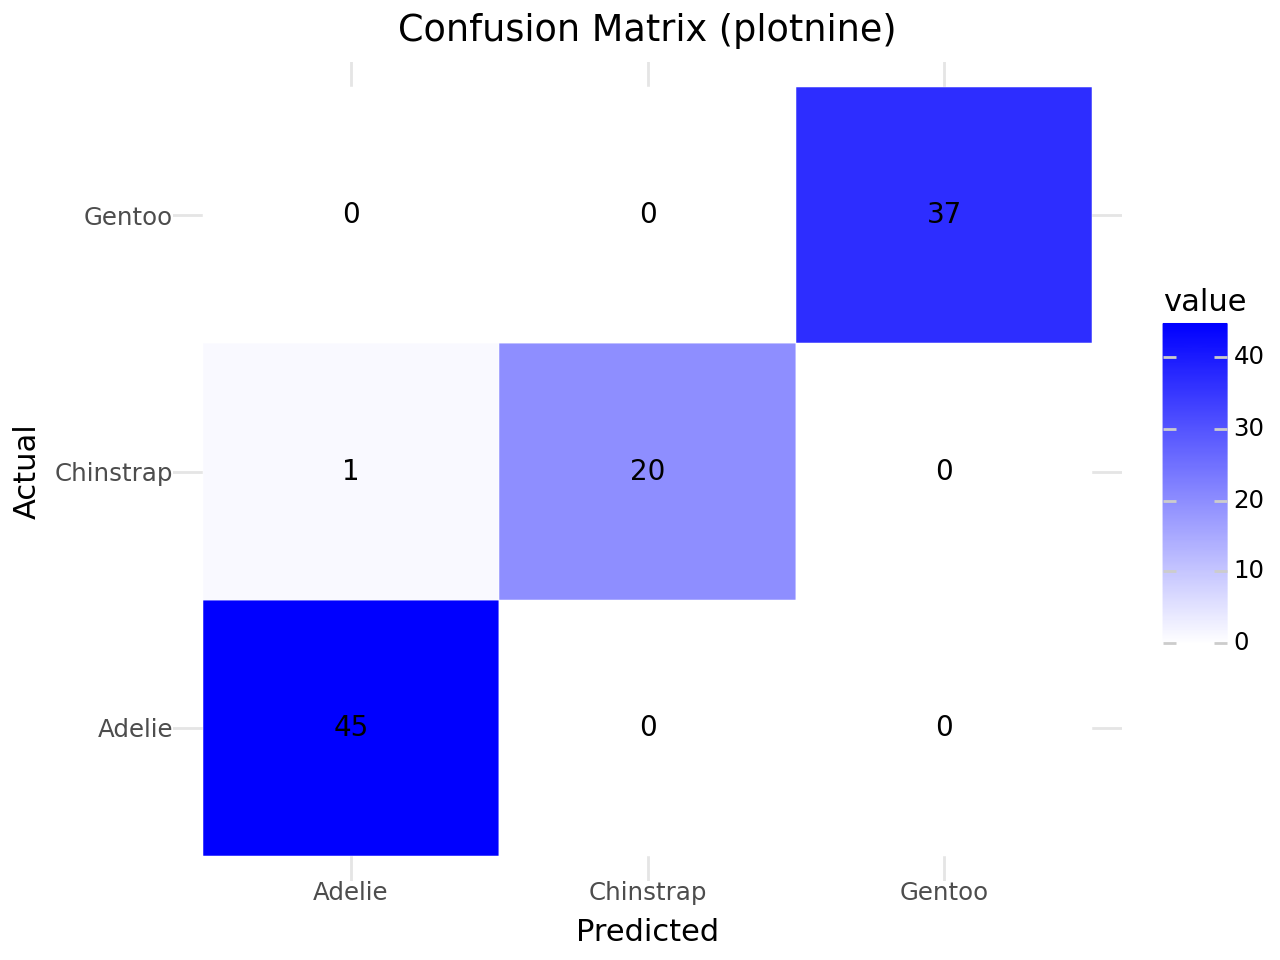

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_tile, geom_text, scale_fill_gradient, labs, theme_minimal, geom_line, geom_abline

#variables
X = penguins_new.drop([col for col in penguins_new.columns if "species" in col], axis=1)
y = penguins['species']
X = X.dropna()
y = y[X.index]

# training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# standardize for kNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# kNN models
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train_scaled, y_train)
y_pred_knn5 = knn5.predict(X_test_scaled)

knn8 = KNeighborsClassifier(n_neighbors=8)
knn8.fit(X_train_scaled, y_train)
y_pred_knn8 = knn8.predict(X_test_scaled)

# decision tree models
dtree3 = DecisionTreeClassifier(max_depth=3, random_state=42)
dtree3.fit(X_train, y_train)
y_pred_dtree3 = dtree3.predict(X_test)

dtree5 = DecisionTreeClassifier(max_depth=5, random_state=42)
dtree5.fit(X_train, y_train)
y_pred_dtree5 = dtree5.predict(X_test)

# compute metrics
def evaluate_model(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix ({model_name}):")
    print(cm)
    
    report = classification_report(y_test, y_pred)
    print(f"\nClassification Report ({model_name}):")
    print(report)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print(f"Accuracy ({model_name}): {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {fscore:.2f}")
    
    return cm

# evaluate kNN models
cm_knn5 = evaluate_model(y_test, y_pred_knn5, "kNN (k=5)")
cm_knn8 = evaluate_model(y_test, y_pred_knn8, "kNN (k=8)")

# evaluate decision tree models
cm_dtree3 = evaluate_model(y_test, y_pred_dtree3, "Decision Tree (depth=3)")
cm_dtree5 = evaluate_model(y_test, y_pred_dtree5, "Decision Tree (depth=5)")

# confusion matrix
def plot_confusion_matrix(cm, labels, title):
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap='Blues')
    plt.colorbar(cax)
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.xticks(np.arange(len(labels)), labels, rotation=45)
    plt.yticks(np.arange(len(labels)), labels)
    plt.show()

plot_confusion_matrix(cm_knn5, labels=['Adelie', 'Chinstrap', 'Gentoo'], title='Confusion Matrix for kNN (k=5)')

# ROC curve for one species using kNN (example)
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
classes = lb.classes_

# Predict probabilities for kNN with k=5
y_score_knn5 = knn5.predict_proba(X_test_scaled)

# Function to plot ROC curves for each species
def plot_roc_curves(y_test_bin, y_score, classes):
    for i, species in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {species}')
        plt.legend(loc="lower right")
        plt.show()

# Plot ROC curves for kNN (k=5)
plot_roc_curves(y_test_bin, y_score_knn5, classes)

plot_roc_curve(fpr, tpr, roc_auc, 'Chinstrap')

# confusion matrix
def plot_confusion_matrix_plotnine(cm, labels):
    cm_df = pd.DataFrame(cm, index=labels, columns=labels).reset_index().melt(id_vars='index')
    p = (
        ggplot(cm_df, aes(x='variable', y='index')) +
        geom_tile(aes(fill='value'), color='white') +
        geom_text(aes(label='value'), size=10) +
        scale_fill_gradient(low='white', high='blue') +
        labs(title='Confusion Matrix (plotnine)', x='Predicted', y='Actual') +
        theme_minimal()
    )
    print(p)

plot_confusion_matrix_plotnine(cm_knn5, labels=['Adelie', 'Chinstrap', 'Gentoo'])
